In [15]:
import pandas as pd
import numpy as np
import scipy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


In [4]:
train_filename = 'customeraffinity.train'
data = pd.read_csv(train_filename, sep=',')
data.index


RangeIndex(start=0, stop=2536704, step=1)

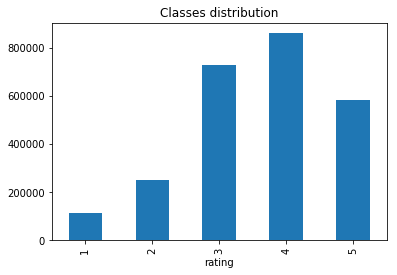

In [7]:
import matplotlib.pyplot as plt
data.groupby(['rating']).count()["new_item"].plot(kind='bar',title="Classes distribution",x="rating",y="counts")
plt.show()

In [8]:
scoring=pd.read_csv('customeraffinity.score',sep=',')
scoring.dtypes
scoring.describe()

,Unnamed: 0,new_user,new_item
count,1.306636e+06,1.306636e+06,1.306636e+06
mean,1.922210e+06,4.674738e+04,1.782689e+03
std,1.109311e+06,2.695706e+04,1.015708e+03
min,3.000000e+00,0.000000e+00,0.000000e+00
25%,9.621250e+05,2.348100e+04,9.150000e+02
50%,1.921724e+06,4.655100e+04,1.705000e+03
75%,2.882706e+06,7.000125e+04,2.689000e+03
max,3.843339e+06,9.370300e+04,3.560000e+03


In [9]:
scoring

,Unnamed: 0,new_user,new_item
0,3,11676,708
1,12,11676,3125
2,16,11676,2029
3,18,11676,1732
4,19,11676,203
5,23,11676,7
6,27,11676,2841
7,30,11676,3467
8,33,11676,1766
9,35,11676,2084


# Data transformation

In [ ]:
#Do not run this cell , load the sparse matrix instead using the code in the following cell
import scipy.sparse as sps
items=data.new_item.value_counts()
products=list(items.index)
numberProducts=len(products)

dicItems=dict()
lstTargets=list()
targetIndex=numberProducts+2
actualItem=numberProducts+1
for i,x in enumerate(products):
    dicItems[x]=i+1

sps_data = sps.lil_matrix((2536704, numberProducts+3))
for i, row in data.iterrows():
    if i>0:
        
        if sps_data[i-1,0]==sps_data[i,0]:
            sps_data[i,1:numberProducts]=sps_data[i-1,1:numberProducts]
            sps_data[i,dicItems[lstTargets[-1][0]]]=lstTargets[-1][1]
        sps_data[i,0]=row['new_user']
    lstTargets.append((row['new_item'],row['rating']))
    sps_data[i,actualItem]=row['new_item']
#Saving the results
sps_csr=sps_data.tocsr()
scipy.sparse.save_npz('matrix_sparse',sps_csr)
    

In [12]:
import scipy.sparse as sps

sps_csr=scipy.sparse.load_npz('matrix_sparse.npz')
targets=list(data.rating)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
sps_csr, targets, test_size=0.4, random_state=0)


# Testing several classifiers

Using decision tree

In [48]:
from sklearn.metrics import mean_squared_error
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
print(clf.score(X_test, y_test))
y_pred=clf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))


0.297886431414
2.01610258189


Using Naive_bayes Multinomial

In [43]:
from sklearn.naive_bayes import MultinomialNB
clfby=MultinomialNB()
clfby.fit(X_train,y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [50]:
y_pred=clfby.predict(X_test)

In [51]:
print(np.sqrt(mean_squared_error(y_test, y_pred)))
clfby.score(X_test,y_test)


2.2828807449


0.26295233383463984

Using Logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression
clfLog=LogisticRegression()
clfLog.fit(X_train,y_train)
y_pred=clfLog.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
clfLog.score(X_test,y_test)


NameError: name 'X_train' is not defined

and why not SVM?

In [14]:
from sklearn import svm
clfSVM=svm.LinearSVC()
clfSVM.fit(X_train,y_train)
y_pred=clfSVM.predict(X_test)

NameError: name 'mean_squared_error' is not defined

In [17]:

print(np.sqrt(mean_squared_error(y_test,y_pred)))
clfSVM.score(X_test,y_test)

1.89446154069


0.11558793789581366